We want to use (train) a Gaussian Process for regression analysis so that we can determin (by fitting) 

In [14]:
using CSV
using DataFrames
using PyPlot
# using StatsBase
using Statistics


using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance
# @sk_import metrics : confusion_matrix

PyObject <function permutation_importance at 0x7f19981a7c80>

In [2]:
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)
rename!(descriptors, "crystal_name" => "xtal")

filename = joinpath(pwd(), "henry_calculations.csv")
henry_df = CSV.read(filename, DataFrame)

filename = joinpath(pwd(), "gcmc_calculations.csv")
gcmc_df = CSV.read(filename, DataFrame)

# for some reason these ones aren't working... LOOk INTO IT
skip_for_now = ["07012N3_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"]
[delete!(descriptors, findfirst(descriptors[:, "xtal"] .== skip_for_now[i])) for i in 1:length(skip_for_now)]

henry_data = outerjoin(henry_df, descriptors, on=["xtal"])
gcmc_data = outerjoin(gcmc_df, descriptors, on=["xtal"])

first(henry_data, 5)

,Qst (kJ/mol),adsorbate,elapsed time (min),err Qst (kJ/mol),err henry coefficient [mmol/(g-bar)]
,Float64?,String?,Float64?,Float64?,Float64?
1,21.329,Kr,1.80109,0.131795,0.0214178
2,24.8751,Xe,1.65142,0.213472,0.0579636
3,10.6927,Kr,5.61557,0.0150828,0.00165314
4,14.8449,Xe,5.29136,0.00924769,0.00422026
5,9.9699,Kr,4.40649,0.0122787,0.00161386


In [3]:
names(henry_data)

33-element Vector{String}:
 "Qst (kJ/mol)"
 "adsorbate"
 "elapsed time (min)"
 "err Qst (kJ/mol)"
 "err henry coefficient [mmol/(g-bar)]"
 "err ⟨U, es⟩ (kJ/mol)"
 "err ⟨U, vdw⟩ (kJ/mol)"
 "henry coefficient [mmol/(g-bar)]"
 "henry coefficient [mol/(kg-Pa)]"
 "henry coefficient [mol/(m³-bar)]"
 "xtal"
 "⟨U, es⟩ (K)"
 "⟨U, es⟩ (kJ/mol)"
 ⋮
 "surface_area_m²g⁻¹"
 "crystal_density"
 "density_of_Carbon"
 "density_of_Hydrogen"
 "density_of_Oxygen"
 "density_of_Nitrogen"
 "density_of_Silicon"
 "density_of_Sulfur"
 "density_of_Boron"
 "density_of_Phosphorus"
 "density_of_Halogens"
 "density_of_Metals"

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [4]:
x_cols = [name for name in names(descriptors) if name != "xtal"]
n_xtals = nrow(henry_data)

X = zeros(n_xtals, length(x_cols))
y = zeros(n_xtals)

for (i, row) in enumerate(eachrow(henry_data))
    [X[i, j] = row[col] for (j, col) in enumerate(x_cols)] # make for loop, and normalize X
    y[i] = row["selectivity Xe/Kr"] # "selectivity " * gas1 * "/" * gas2
end
X # look at y too!

1218×14 Matrix{Float64}:
  3.84928  0.2  4175.64  1049.37   …  0.0  0.00974344  0.0  0.0  0.0
  3.84928  0.2  4175.64  1049.37      0.0  0.00974344  0.0  0.0  0.0
 19.7302   0.6  3156.96   585.477     0.0  0.00227564  0.0  0.0  0.0
 19.7302   0.6  3156.96   585.477     0.0  0.00227564  0.0  0.0  0.0
 26.1625   0.8  3407.23   458.054     0.0  0.00142936  0.0  0.0  0.0
 26.1625   0.8  3407.23   458.054  …  0.0  0.00142936  0.0  0.0  0.0
  7.82083  0.4  2565.59  1100.22      0.0  0.00466863  0.0  0.0  0.0
  7.82083  0.4  2565.59  1100.22      0.0  0.00466863  0.0  0.0  0.0
 14.8469   0.4  3345.75   703.114     0.0  0.00194218  0.0  0.0  0.0
 14.8469   0.4  3345.75   703.114     0.0  0.00194218  0.0  0.0  0.0
  9.33026  0.7  5261.66   421.68   …  0.0  0.00239773  0.0  0.0  0.0
  9.33026  0.7  5261.66   421.68      0.0  0.00239773  0.0  0.0  0.0
  9.94867  0.7  5452.36   383.117     0.0  0.00209882  0.0  0.0  0.0
  ⋮                                ⋱       ⋮                     
 25.838    0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25);

In [ ]:
# train on training data
kernel = Matern(nu=2.5, length_scale=0.25)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=true)
gpr.fit(X_train, y_train)

In [17]:
gpr.get_params() # why isn't length scale being optimized?

Dict{Any, Any} with 10 entries:
  "normalize_y"                 => true
  "optimizer"                   => "fmin_l_bfgs_b"
  "alpha"                       => 1.0e-10
  "kernel__length_scale_bounds" => (1.0e-5, 100000.0)
  "kernel"                      => PyObject Matern(length_scale=0.25, nu=2.5)
  "kernel__nu"                  => 2.5
  "random_state"                => nothing
  "kernel__length_scale"        => 0.25
  "n_restarts_optimizer"        => 0
  "copy_X_train"                => true

In [6]:
# get predictions on test data
y_pred = gpr.predict(X_test)

305-element Vector{Float64}:
  5.20695853746734
  4.03234943202343
  4.193811609466098
  5.186223692561514
  3.769305476971882
  3.271353120534662
  4.193811609466098
  2.843593405587539
  2.928468881295318
  3.821725669423337
  2.6078779408843697
  4.737806165182201
  3.50709751299966
  ⋮
 16.94330754652097
  4.167939468088406
  3.905961423015491
  4.193811609466098
  4.333441871534045
  3.700025165743707
  4.697275513309159
  4.552426123398665
 20.368232944677782
  2.739949909530204
  3.0102871976554746
  3.2577283576312905

In [12]:
# compute RMSE, R2 on test data
rmse = sqrt(mean((y_test - y_pred).^2))
r2 = gpr.score(X_test, y_test)

0.9480667056321254

In [15]:
# permutation importance
feature_importances = permutation_importance(gpr, X_test, y_test)

Dict{Any, Any} with 3 entries:
  "importances_std"  => [0.00214818, 0.0739119, 0.000498252, 0.000489471, 4.982…
  "importances_mean" => [0.942511, 0.34353, 0.947628, 0.94744, 2.4416e-5, 8.754…
  "importances"      => [0.943843 0.944272 … 0.944328 0.941247; 0.475295 0.3323…

## Parity Plot

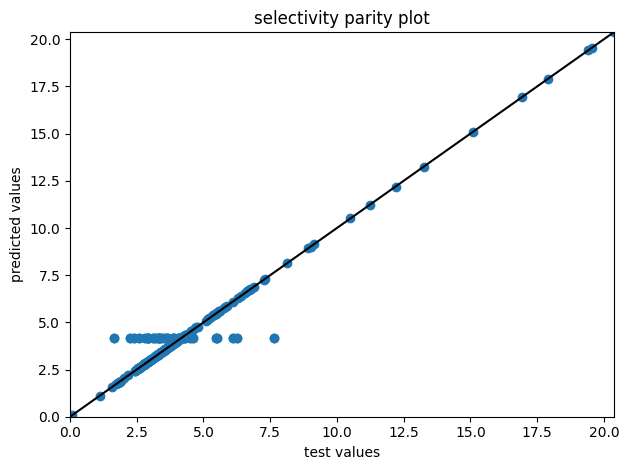

In [16]:
figure()

xmax = maximum(max.(y_test, y_pred))
x = range(0.0, stop=xmax, length=length(y_test))
y = x
plot(x, y, color="k")

scatter(y_test, y_pred)

xlim([0.0, xmax])
ylim([0.0, xmax])

title("selectivity parity plot")
xlabel("test values")
ylabel("predicted values")

tight_layout()